## Imports

In [2]:
import sagemaker
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pathlib
import tarfile
import pandas as pd

## Clients

In [3]:
sagemaker_client = sagemaker.Session().sagemaker_runtime_client

## Constants

In [4]:
BIRDS_200_DIR = "CUB_200_2011"
BIRDS_200_DATASET_S3_URL = f"https://s3.amazonaws.com/fast-ai-imageclas/{BIRDS_200_DIR}.tgz"

ML_DIR = pathlib.Path("/opt/ml/")
ML_DATA_DIR = ML_DIR / "data"
ML_DATA_BIRDS_200_DIR = ML_DATA_DIR / BIRDS_200_DIR
CLASSES_TXT = ML_DATA_BIRDS_200_DIR / "classes.txt"

CLASS_ID = "class_id"
CLASS_NAME = "class_name"

OBJECT_DETECTION_ENDPOINT = "object-detection-2023-05-12-14-39-28-770"
THRESH = 0.4
CLASS_IDS = [17, 36, 47, 68, 73]

## Create mapping from class-id to class-name

#### Create directories

In [5]:
ML_DIR.mkdir(exist_ok=True)
ML_DATA_DIR.mkdir(exist_ok=True)

#### Download the dataset

In [6]:
def download(url, download_dir, force=False):
    filename = url.split("/")[-1]
    filepath = download_dir / filename
    if force or not filepath.exists():
        urllib.request.urlretrieve(url, filepath)
    return filepath

In [7]:
dataset_path = download(BIRDS_200_DATASET_S3_URL, download_dir=ML_DATA_DIR)
print(dataset_path)

/opt/ml/data/CUB_200_2011.tgz


#### Extract the dataset

In [8]:
compressed = tarfile.open(dataset_path)
compressed.extractall(ML_DATA_DIR)

#### Create class_id2class_name mapping

In [9]:
classes_df = pd.read_csv(CLASSES_TXT, sep=" ", names=[CLASS_ID, CLASS_NAME], header=None)
class_id2class_name = dict(zip(classes_df[CLASS_ID], classes_df[CLASS_NAME]))

## Prediction

In [10]:
def show_predictions(img_path):
    predictions = predict(img_path)
    if predictions:
        (class_name, conf, x0, x1, y0, y1) = predictions[0]
        show(img_path, class_name, x0, x1, y0, y1)
        return True
    else:
        print(f"{img_path} -- No Prediction")
        return False


def predict(img_path):
    data = None
    with open(img_path, "rb") as image:
        data = bytearray(image.read())
    
    if data is None:
        raise Exception(f"image-path={img_path}")
        
    response = sagemaker_client.invoke_endpoint(
        EndpointName=OBJECT_DETECTION_ENDPOINT,
        Body=data,
        ContentType="image/jpeg",
    )
    results = response["Body"].read()
    detections = json.loads(results)
    found_detections = find_detections(detections["prediction"])
    return found_detections


def find_detections(detections):
    found_detections = []
    for detection in detections:
        (klass, conf, x0, y0, x1, y1) = detection
        if conf < THRESH:
            continue
        class_id = CLASS_IDS[int(klass)]
        class_name = class_id2class_name[class_id]
        found_detections.append((class_name, conf, x0, x1, y0, y1))
    return found_detections


def show(img_path, class_name, x0, x1, y0, y1):
    img = mpimg.imread(img_path)
    height = img.shape[0]
    width = img.shape[1]
    xmin = int(x0 * width)
    ymin = int(y0 * height)
    xmax = int(x1 * width)
    ymax = int(y1 * height)
    rect = plt.Rectangle(
        (xmin, ymin),
        xmax - xmin,
        ymax - ymin,
        fill=False,
        linewidth=3.5,
        color="#76FF7B",
    )
    plt.gca().add_patch(rect)
    plt.imshow(img)
    plt.text(10, 20, class_name, color='r', fontsize=16, fontweight="book")
    plt.show()

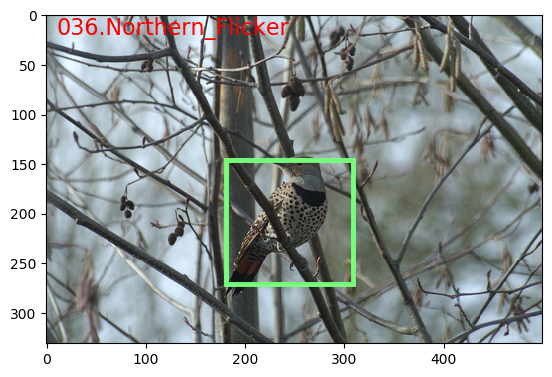

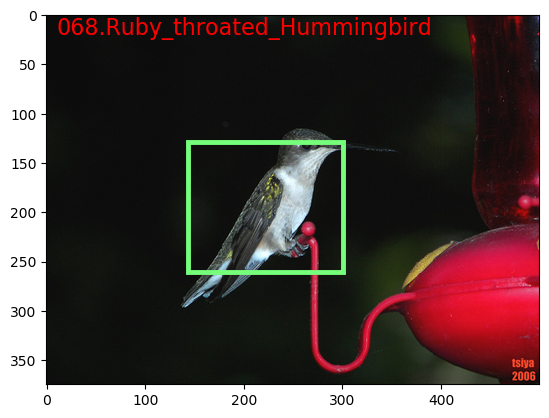

True

In [11]:
show_predictions("test_images/Northern_Flicker_0136_28918.jpg")
show_predictions("test_images/Ruby_Throated_Hummingbird_0025_57835.jpg")